In [153]:
# all imports
import numpy as np
import pickle
from scipy.stats import zscore

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


In [154]:
# load the data ~5gb
data = pickle.load(open('data/dataset.pickle', 'rb'))
print(data['info'])

responses: (11983 neurons x 7018 timebins) responses for each neuron at each time 
run_speed: (7018 timebins x 1) run speed for mouse at each time 
neuron_pos: (11983 neurons x 3) xyz position for each neuron 
pupil_area: (7018 timebins x 1) area of pupil for mouse at each time 
pupil_pos: (7018 timebins x 2) xy position of pupil for mouse at each time 
behavior_embedding: (7018 timebins x 1000) the behavior embedded in a vector size 1000 at each time 
movie: (7018 timebins x 240 x 320) the behavior movie at each time (corresponding to the embedding) 
movie_mask: (240 x 320 x 1) a mask to generate the movie, not important 
info: this text 



In [155]:
TRAIN_TEST_SPLIT = 6500 # Number of datapoints to train on

zscored_X = zscore(data['responses'], axis=1)

train_X = zscored_X[:, :TRAIN_TEST_SPLIT]
train_Y = data['pupil_area'][:TRAIN_TEST_SPLIT]
test_X = zscored_X[:, TRAIN_TEST_SPLIT:]
test_Y = data['pupil_area'][TRAIN_TEST_SPLIT:]

In [156]:
# Q: How well does a linear regression perform? A: A vanilla linear_regression gets an R^2 of 0.63
linear_regression = LinearRegression().fit(train_X.T, train_Y)
linear_regression.score(test_X.T, test_Y)

KeyboardInterrupt: 

In [ ]:
# Q: can we do better with regularizations?
# A: yes, but the best regularization coeff is 1200
# => this means that we have so many parameters (~10k), but so few samples that we are overfitting.

l2_regularization_weights = [0.5, 0.6, 0.7, 0.8, 0.9] + [10**i for i in range(6)]
models = [Ridge(alpha=l2_regularization_weights[alpha_i]) for alpha_i in range(len(l2_regularization_weights))]

for model_i in range(len(models)):    
    models[model_i].fit(train_X.T, train_Y)
    score = models[model_i].score(test_X.T, test_Y)
    print(f'alpha: {l2_regularization_weights[model_i]}, score: {score}')

alpha: 0.5, score: 0.6373147108290406
alpha: 0.6, score: 0.6373270206745474
alpha: 0.7, score: 0.637339427695114
alpha: 0.8, score: 0.6373517054056959
alpha: 0.9, score: 0.6373642166521614
alpha: 1, score: 0.6373764654365212
alpha: 10, score: 0.638481181455059
alpha: 100, score: 0.648304349854647
alpha: 1000, score: 0.692624640582395
alpha: 10000, score: 0.7064503286544386
alpha: 100000, score: 0.5145483396669331


In [ ]:
# Q: so we do a PCA, but how many components should we pick? Capture 95% of variance
# This is just for graphing

pca = PCA(n_components=0.95)
pca.fit(zscored_X.T)
reduced_X = pca.transform(data['responses'].T)

pca_graph = PCA(n_components=0.97)
pca_graph.fit(zscored_X.T)
reduced_X = pca_graph.transform(data['responses'].T)


In [ ]:
pickle.dump(pca, open('data/pca.pickle', 'wb'))

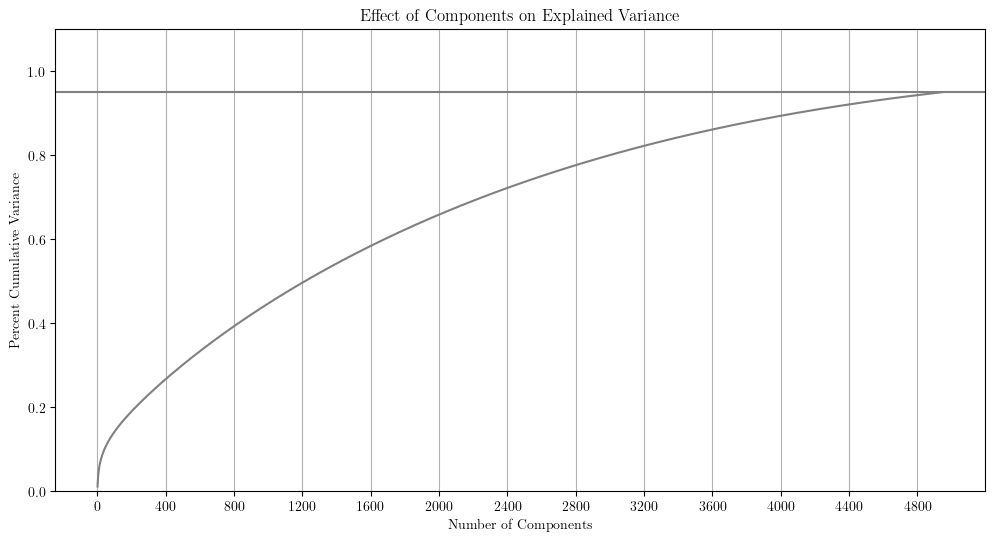

In [157]:
# graph showing how the number of components captures the variance

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

number_of_components = pca_graph.components_.shape[0]

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, number_of_components + 1, step=1)
y = np.cumsum(pca_graph.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, c="gray")

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_components, step=400)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Percent Cumulative Variance')

plt.title('Effect of Components on Explained Variance')

plt.axhline(y=0.95, color='gray', linestyle='-')

ax.grid(axis='x')
plt.show()


In [ ]:
print(reduced_X.shape)

TRAIN_TEST_SPLIT = 6500 # Number of datapoints to train on

train_X = reduced_X[:TRAIN_TEST_SPLIT, :]
train_Y = data['pupil_area'][:TRAIN_TEST_SPLIT]
test_X = reduced_X[TRAIN_TEST_SPLIT:, :]
test_Y = data['pupil_area'][TRAIN_TEST_SPLIT:]

linear_regression = LinearRegression().fit(train_X, train_Y)
linear_regression.score(test_X, test_Y)

(7018, 4950)


0.3718175414003423

In [ ]:
# Let's retry on the PCA's data

l2_regularization_weights = [0.5, 0.6, 0.7, 0.8, 0.9] + [10**i for i in range(6)]
models = [Ridge(alpha=l2_regularization_weights[alpha_i]) for alpha_i in range(len(l2_regularization_weights))]

for model_i in range(len(models)):    
    models[model_i].fit(train_X, train_Y)
    score = models[model_i].score(test_X, test_Y)
    print(f'alpha: {l2_regularization_weights[model_i]}, score: {score}')

alpha: 0.1, score: 0.3718184613388492
alpha: 1, score: 0.3718186030697985
alpha: 10, score: 0.3718237144991704
alpha: 100, score: 0.3718581596445192
alpha: 1000, score: 0.3722175715775452
alpha: 10000, score: 0.3757610363155939
alpha: 100000, score: 0.40731544565667255
alpha: 1000000, score: 0.5524651898685834
alpha: 10000000, score: 0.6883645468213002
alpha: 100000000, score: 0.6880015787882805
alpha: 1000000000, score: 0.5016055975951563
